In [1]:
%load_ext autoreload
%autoreload 2

### load data

In [4]:
import pandas as pd
import numpy as np
import chardet


In [5]:
with open("./data/small_data.csv", 'rb') as file:
    print(chardet.detect(file.read()))

{'encoding': 'Windows-1252', 'confidence': 0.73, 'language': ''}


In [6]:
raw_txsn = pd.read_csv("./data/small_data.csv", encoding="cp1252")

In [8]:
# imbalanced data
raw_txsn.Category.value_counts()

Category
Electronics                  768
Home                         577
Clothes                      466
Entertainment                407
Personal_Care                401
Vacation                     199
Auto                         178
Food                         137
Utilities                    133
Kids                         114
Subscriptions_Memberships     85
Medical                        2
Personal Care                  1
Debt                           1
Savings                        1
Name: count, dtype: int64

In [11]:
combined_cats = ['Subscriptions_Memberships', 'Medical', 'Personal Care', 'Debt', 'Savings']

txsn = raw_txsn.copy()
txsn['label'] = txsn['Category']
txsn.loc[txsn.label.isin(combined_cats), 'label'] = 'Others'

In [12]:
txsn.label.value_counts(normalize=True)

label
Electronics      0.221326
Home             0.166282
Clothes          0.134294
Entertainment    0.117291
Personal_Care    0.115562
Vacation         0.057349
Auto             0.051297
Food             0.039481
Utilities        0.038329
Kids             0.032853
Others           0.025937
Name: proportion, dtype: float64

In [119]:
num_cat = txsn.label.nunique()
num_cat

11

### process data

In [47]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import re
from unidecode import unidecode
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

In [23]:
unique_cats = list(txsn['label'].unique())

label_encoder = LabelEncoder()
integer_encoded_cat = label_encoder.fit_transform(unique_cats)

onehot_encoder = OneHotEncoder(sparse_output=False)
onehot_encoded_cat = onehot_encoder.fit_transform(integer_encoded_cat.reshape(-1, 1))

category_mapping = dict(zip(unique_cats, onehot_encoded_cat))

In [52]:
# process transaction name
txsn['name'] = txsn['Description']
# lowercase
txsn['name'] = txsn['name'].apply(lambda x: x.strip().lower())
# convert non English letter to the closest English letter
txsn['name'] = txsn['name'].apply(lambda x: unidecode(x))
# remove non English letter
txsn['name'] = txsn['name'].apply(lambda x: re.sub(r'[^a-zA-Z ]', "", x))
# remove extra space
txsn['name'] = txsn['name'].apply(lambda x: re.sub(r'\s+', " ", x))
# remove single letter
txsn['name'] = txsn['name'].apply(lambda x: re.sub(r'\b[a-zA-Z]\b', "", x))
# remove word with length >= 15
txsn['name'] = txsn['name'].apply(lambda x: re.sub(r'\b[a-zA-Z]{15,}\b', "", x))
# remove stopwords
txsn['name'] = txsn['name'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
# remove duplicate words while preserving the order of occurance
txsn['name'] = txsn['name'].apply(lambda x: ' '.join(list(dict.fromkeys(x.split()))))

In [55]:
# only keep the necessary columns
txsn = txsn.assign(tokenized='', tok_cat='')
txsn = txsn[['name', 'label', 'tokenized', 'tok_cat']]

In [59]:
# ensure that there is no missing values
txsn.isna().sum()

name         0
label        0
tokenized    0
tok_cat      0
dtype: int64

### word-embedding

In [88]:
import tensorflow as tf
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split

In [65]:
# load the BERT tokenizer
# https://huggingface.co/google-bert/bert-base-uncased
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [66]:
# tokenize transaction name
tokenized_desc = [tokenizer.tokenize(text) for text in txsn['name']]
txsn['tokenized'] = tokenized_desc

In [68]:
# Convert the tokenized sequences to IDs
tokenized_desc_ids = [tokenizer.convert_tokens_to_ids(tokens) for tokens in tokenized_desc]
txsn['tokenized_ids'] = tokenized_desc_ids

In [71]:
# Find the maximum length of the tokenized sequences
actual_max = max([len(tokens) for tokens in tokenized_desc_ids])
print("Max length in the data:", actual_max)

Max length in the data: 30


In [83]:
# Pad the sequences to the max_len
max_len = 30
padded_desc = tf.keras.preprocessing.sequence.pad_sequences(tokenized_desc_ids, maxlen=max_len, 
                                                            padding='post', truncating='post')
txsn['tokenized_padded'] = np.array(padded_desc).tolist()

In [84]:
# Map the Category and Sub_Category values to the corresponding one-hot encoded vectors
txsn['tok_cat'] = txsn['label'].apply(lambda x: category_mapping.get(x))

In [85]:
X, y = txsn["tokenized_padded"].tolist(), txsn["tok_cat"].tolist()

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [104]:
print('label shape before %s' % str(np.array(y_train).shape))
y_train = np.argmax( np.array(y_train), axis=1 )
print('label shape after %s' % str(y_train.shape))

label shape before (2949, 11)
label shape after (2949,)


In [105]:
print('label shape before %s' % str(np.array(y_test).shape))
y_test = np.argmax( np.array(y_test), axis=1 )
print('label shape after %s' % str(y_test.shape))

label shape before (521, 11)
label shape after (521,)


### model training

In [124]:
import time

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

from transformers import BertModel, BertForSequenceClassification

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [131]:
X_trainT = torch.tensor(X_train)
X_testT = torch.tensor(X_test)

y_trainT = torch.tensor(y_train).long()
y_testT = torch.tensor(y_test).long()

In [174]:
train_data = TensorDataset(X_trainT,y_trainT)
test_data  = TensorDataset(X_testT,y_testT)

batch_size = 16
train_loader = DataLoader(
    train_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader  = DataLoader(
    test_data, batch_size=batch_size, shuffle=False)

In [120]:
class CategorizerModel(nn.Module):

    def __init__(self, num_cat):
        super().__init__()
        self.bert_model = BertForSequenceClassification.from_pretrained(
            'bert-base-uncased', num_labels= num_cat)      
        self.num_cat = num_cat

    def forward(self, x):
        outputs = self.bert_model(x)
        logits = outputs.logits
        return logits

In [121]:
num_cat

11

In [195]:
cat_model = CategorizerModel(num_cat=num_cat)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [133]:
# test if the model is working or not
# X_qa = next(iter(test_loader))[0]
# yhat_qa = cat_model(X_qa)

In [196]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [197]:
# using the parameters recommended in the repo
learning_rate = 1e-5
epochs = 10

# optimizer
optimizer = optim.AdamW(
    cat_model.parameters(), lr=learning_rate, weight_decay=0.01)
    
# # scheduler
scheduler = ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# loss function
lossfun = nn.CrossEntropyLoss(reduction='sum')

In [198]:
history = {
    'train_loss': [], 
    'train_acc': [], 
    'val_loss': [], 
    'val_acc': []}
cat_model = cat_model.to(device)
best_val_loss = float('inf')
no_improvement_epochs = 0
batch_print_interval = 10
early_stop = 5

In [199]:
start_time = time.process_time()

for epoch in range(epochs):

    # switch to train mode
    cat_model.train()

    total_train_loss = 0
    correct_train = 0
    trained_sample = 0

    for i, batch in enumerate(train_loader):
        X, y = [item.to(device) for item in batch[:2]]

        # forward pass 
        yHat = cat_model(X)
        loss = lossfun(yHat,y)

        total_train_loss += loss.item()
        correct_train += (yHat.argmax(dim=1) == y).sum().item()
        trained_sample += batch_size

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # check val results during training
        if (i + 1) % batch_print_interval == 0:
            cat_model.eval()
            total_val_loss = 0
            correct_val = 0

            with torch.no_grad():
                for batch in test_loader:
                    X, y = [item.to(device) for item in batch[:2]]

                    # pred and get loss
                    yHat = cat_model(X)
                    loss = lossfun(yHat,y)

                    total_val_loss += loss.item()
                    correct_val += (yHat.argmax(dim=1) == y).sum().item()
            # end of eval loop

            avg_val_loss = total_val_loss / len(test_loader)
            val_acc = correct_val / len(test_loader.dataset)
            avg_train_loss = total_train_loss / (i + 1)  # current average for this epoch up to batch i
            train_acc = correct_train / trained_sample
            print(f"Epoch {epoch}/{epochs-1} - Batch {i+1}/{len(train_loader)} "
                f"- Training loss: {avg_train_loss:.4f}, Training Acc: {train_acc:.4f}, "
                f"Validation loss: {avg_val_loss:.4f}, Validation Acc: {val_acc:.4f}")
            cat_model.train()  # Switch back to training mode

            elapsed_time = time.process_time() - start_time
            print(f'Elapsed time: {elapsed_time:.2f} sec')

    # end of batch loop
    history['train_loss'].append(avg_train_loss)
    history['train_acc'].append(train_acc)        
    history['val_loss'].append(avg_val_loss)
    history['val_acc'].append(val_acc)

    # Update learning rate
    scheduler.step(avg_val_loss)
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        no_improvement_epochs = 0
    else:
        no_improvement_epochs += 1           
    if no_improvement_epochs >= early_stop:
        print(f"Stopping early due to no improvement after {early_stop} epochs.")
        break

Epoch 0/9 - Batch 10/184 - Training loss: 37.8991, Training Acc: 0.1625, Validation loss: 35.4343, Validation Acc: 0.1881
Elapsed time: 1.23 sec


Epoch 0/9 - Batch 20/184 - Training loss: 36.5057, Training Acc: 0.2062, Validation loss: 34.4768, Validation Acc: 0.2265
Elapsed time: 2.31 sec
Epoch 0/9 - Batch 30/184 - Training loss: 35.7586, Training Acc: 0.2333, Validation loss: 34.3123, Validation Acc: 0.2169
Elapsed time: 3.50 sec
Epoch 0/9 - Batch 40/184 - Training loss: 35.4182, Training Acc: 0.2453, Validation loss: 33.5769, Validation Acc: 0.2438
Elapsed time: 4.62 sec
Epoch 0/9 - Batch 50/184 - Training loss: 35.2682, Training Acc: 0.2500, Validation loss: 33.0896, Validation Acc: 0.3109
Elapsed time: 5.75 sec
Epoch 0/9 - Batch 60/184 - Training loss: 34.9432, Training Acc: 0.2573, Validation loss: 31.9912, Validation Acc: 0.3800
Elapsed time: 6.89 sec
Epoch 0/9 - Batch 70/184 - Training loss: 34.7619, Training Acc: 0.2679, Validation loss: 32.0774, Validation Acc: 0.3512
Elapsed time: 8.02 sec
Epoch 0/9 - Batch 80/184 - Training loss: 34.3539, Training Acc: 0.2734, Validation loss: 31.2170, Validation Acc: 0.3916
Elapsed 

In [200]:
# save model
cat_model.to('cpu')
cat_model_save_path = 'model/test_model.pt'
torch.save(cat_model.state_dict(), cat_model_save_path)

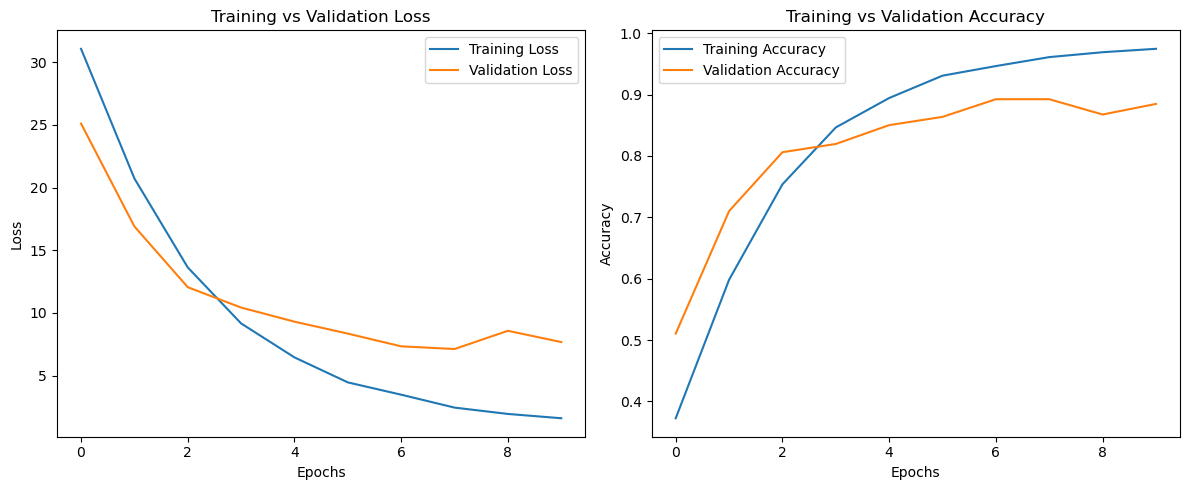

In [201]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Training Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

### quick test inference

In [215]:
sample_test_df = txsn[['name', 'label']].sample(5)
sample_test_df

,name,label
1977,doc martens adrian,Clothes
2436,fisherprice linkimals smooth moves sloth music...,Kids
2804,oneplus pro,Electronics
851,grand mercure,Vacation
1353,samsung galaxy plus led wallet cover,Electronics


In [216]:
sample_test_df['Tokenized'] = [
    tokenizer.tokenize(text) for text in sample_test_df['name']]
sample_test_df['Tokenized_ids'] = [
    tokenizer.convert_tokens_to_ids(tokens) for tokens in sample_test_df['Tokenized'].to_list()]


In [220]:
sample_maxlen = max([len(tokens) for tokens in sample_test_df['Tokenized_ids'].to_list()])
sample_maxlen

13

In [221]:
sample_padded_desc = tf.keras.preprocessing.sequence.pad_sequences(
    sample_test_df['Tokenized_ids'].to_list(), maxlen=sample_maxlen, 
    padding='post', truncating='post')
sample_test_df['Tokenized_padded'] = np.array(sample_padded_desc).tolist()

In [222]:
sample_test_df

,name,label,Tokenized,Tokenized_ids,Tokenized_padded
1977,doc martens adrian,Clothes,"[doc, mart, ##ens, adrian]","[9986, 20481, 6132, 7918]","[9986, 20481, 6132, 7918, 0, 0, 0, 0, 0, 0, 0,..."
2436,fisherprice linkimals smooth moves sloth music...,Kids,"[fisher, ##pr, ##ice, link, ##ima, ##ls, smoot...","[8731, 18098, 6610, 4957, 9581, 4877, 5744, 58...","[8731, 18098, 6610, 4957, 9581, 4877, 5744, 58..."
2804,oneplus pro,Electronics,"[one, ##pl, ##us, pro]","[2028, 24759, 2271, 4013]","[2028, 24759, 2271, 4013, 0, 0, 0, 0, 0, 0, 0,..."
851,grand mercure,Vacation,"[grand, mer, ##cure]","[2882, 21442, 23887]","[2882, 21442, 23887, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
1353,samsung galaxy plus led wallet cover,Electronics,"[samsung, galaxy, plus, led, wallet, cover]","[19102, 9088, 4606, 2419, 15882, 3104]","[19102, 9088, 4606, 2419, 15882, 3104, 0, 0, 0..."


In [237]:
predict_input_ids = torch.tensor(
    np.array(sample_padded_desc).tolist(), dtype=torch.long)
predict_dataset = TensorDataset(predict_input_ids)
predict_dataloader = DataLoader(predict_dataset, 
                batch_size=1)

print("Length of predict_dataloader:", len(predict_dataloader))

Length of predict_dataloader: 5


In [233]:
loaded_model = CategorizerModel(num_cat=num_cat)
# Load the saved model weights
loaded_state_dict = torch.load(cat_model_save_path)
# Load the model state dictionary into the model architecture
loaded_model.load_state_dict(loaded_state_dict)
# Set the model to evaluation mode
loaded_model.eval()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CategorizerModel(
  (bert_model): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_featur

In [259]:
txt_mapper = dict(zip(unique_cats, integer_encoded_cat))
inverse_dict = {v: k for k, v in txt_mapper.items()}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

loaded_model.to(device)

pred_cat_txt = []
for batch in predict_dataloader:
    input_ids = batch[0].to(device)
    with torch.no_grad():
        category_probs = loaded_model(input_ids)
        category_predictions = torch.argmax(category_probs,axis=1).item()
        pred_cat_txt.append(inverse_dict.get(category_predictions, ''))

Using device: cuda


In [254]:
sample_test_df['pred_cat'] = pred_cat_txt

In [255]:
sample_test_df

,name,label,Tokenized,Tokenized_ids,Tokenized_padded,pred_cat
1977,doc martens adrian,Clothes,"[doc, mart, ##ens, adrian]","[9986, 20481, 6132, 7918]","[9986, 20481, 6132, 7918, 0, 0, 0, 0, 0, 0, 0,...",Clothes
2436,fisherprice linkimals smooth moves sloth music...,Kids,"[fisher, ##pr, ##ice, link, ##ima, ##ls, smoot...","[8731, 18098, 6610, 4957, 9581, 4877, 5744, 58...","[8731, 18098, 6610, 4957, 9581, 4877, 5744, 58...",Kids
2804,oneplus pro,Electronics,"[one, ##pl, ##us, pro]","[2028, 24759, 2271, 4013]","[2028, 24759, 2271, 4013, 0, 0, 0, 0, 0, 0, 0,...",Electronics
851,grand mercure,Vacation,"[grand, mer, ##cure]","[2882, 21442, 23887]","[2882, 21442, 23887, 0, 0, 0, 0, 0, 0, 0, 0, 0...",Vacation
1353,samsung galaxy plus led wallet cover,Electronics,"[samsung, galaxy, plus, led, wallet, cover]","[19102, 9088, 4606, 2419, 15882, 3104]","[19102, 9088, 4606, 2419, 15882, 3104, 0, 0, 0...",Electronics
